In [1]:
# print version / should be 1.6.3
println(versioninfo())

# load centralized paths dictionary
using YAML
PATHS_FILE = "../../../PATHS.yml"
PATHS = YAML.load_file(PATHS_FILE);

"""
    load_path(keys::Vector{String}):String

Return the absolute path for a requested item within the nested PATHS dictionary.
"""
function loadpath(keys::Vector{String}):String
    # recusively assemble paths from keys
    requested_path = foldl((x, y) -> getindex(x, y), keys; init=PATHS)
    # rephrase abs path from relative paths to be platform independent.
    realpath(joinpath(splitdir(realpath(PATHS_FILE))[1], requested_path))
end;

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  __LMOD_REF_COUNT_JULIA_DEPOT_PATH = /home/biotoml/.julia:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg:1
  JULIA_DEPOT_PATH = /home/biotoml/lsm/src/.julia/v1.6_depot:/home/biotoml/.julia:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg
  __LMOD_REF_COUNT_JULIA_LOAD_PATH = @:1;@v#.#:1;@stdlib:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6:1
  JULIA_PROJECT = /home/biotoml/lsm/src/.julia/v1.6_regrid
  JULIA_ROOT = /sw/comp/julia/1.6.3/rackham
  JULIA_LOAD_PATH = @:@v#.#:@stdlib:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6
  JULIA_NUM_THREADS = 2
nothing


In [2]:
using IntervalSets
using NCDatasets
using Plots
using Revise
using StatsBase

In [65]:
include("./regridding.jl")
include("./spatialplotting.jl")
include("./utils_netcdf.jl")

vectors_product

---
---

# Regridding of earth observations

With `GriddingMachine.jl` we were able [to download](./03_sources_for_clima_land.ipynb) a bunch of remote sensing data. As we want to use it all on the same resolution we need to regrid them. Thus, regridding of NetCDF files using different mathematical operations is implememnted in this notebook.

## Example of temporal dataset

The global leaf area index dataset includes temporal resolution (batches of 8 days a year). We can regrid it to an arbitrary scale. First we load the dataset using the `NCDatasets.jl` package.

In [7]:
file = "/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5662e9e197e74055f9582b9ff35a9612e2a15ea7/LAI_MODIS_2X_8D_2020_V1.nc"

"/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5662e9e197e74055f9582b9ff35a9612e2a15ea7/LAI_MODIS_2X_8D_2020_V1.nc"

In [8]:
ds = NCDataset(file, "r")

NCDataset: /home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5662e9e197e74055f9582b9ff35a9612e2a15ea7/LAI_MODIS_2X_8D_2020_V1.nc
Group: /

Dimensions
   lon = 720
   lat = 360
   ind = 46

Variables
  lon   (720)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     unit                 = °
     description          = Longitude

  lat   (360)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     unit                 = °
     description          = Latitude

  ind   (46)
    Datatype:    Int64
    Dimensions:  ind
    Attributes:
     unit                 = -
     description          = Cycle index

  data   (720 × 360 × 46)
    Datatype:    Float64
    Dimensions:  lon × lat × ind
    Attributes:
     change1              = The original lat was from north to south, and we reorgainized it from south to north
     about                = This content is regridded from MODIS data
     year                 = 2011
     doi                  = 10.1016/j.rse.2011.01.00

Then, we define the regridded dataset using a 3 dimensional regridder. It should include 39 longitudinal intervals, 60 intervals on latitude and 2 temporal cycles.

In [9]:
rgo = Regridder3D(39, 60, 2;indmin=1., indmax=3.)

Regridder3D(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -90.0, 90.0, 39), RegridAxis{Int64, Float64}("lon", -180.0, 180.0, 60), RegridAxis{Int64, Float64}("ind", 1.0, 3.0, 2)])

In [10]:
# the new file should be named like this:
new_file = "newtrial2.nc";

For regridding we use the weighted mean; and finally regrid it:

In [11]:
regridding_op = mean

a=regrid_dataset(new_file, rgo, ds, ["data", "std"], regridding_op; force=true);

Here one can see the results:

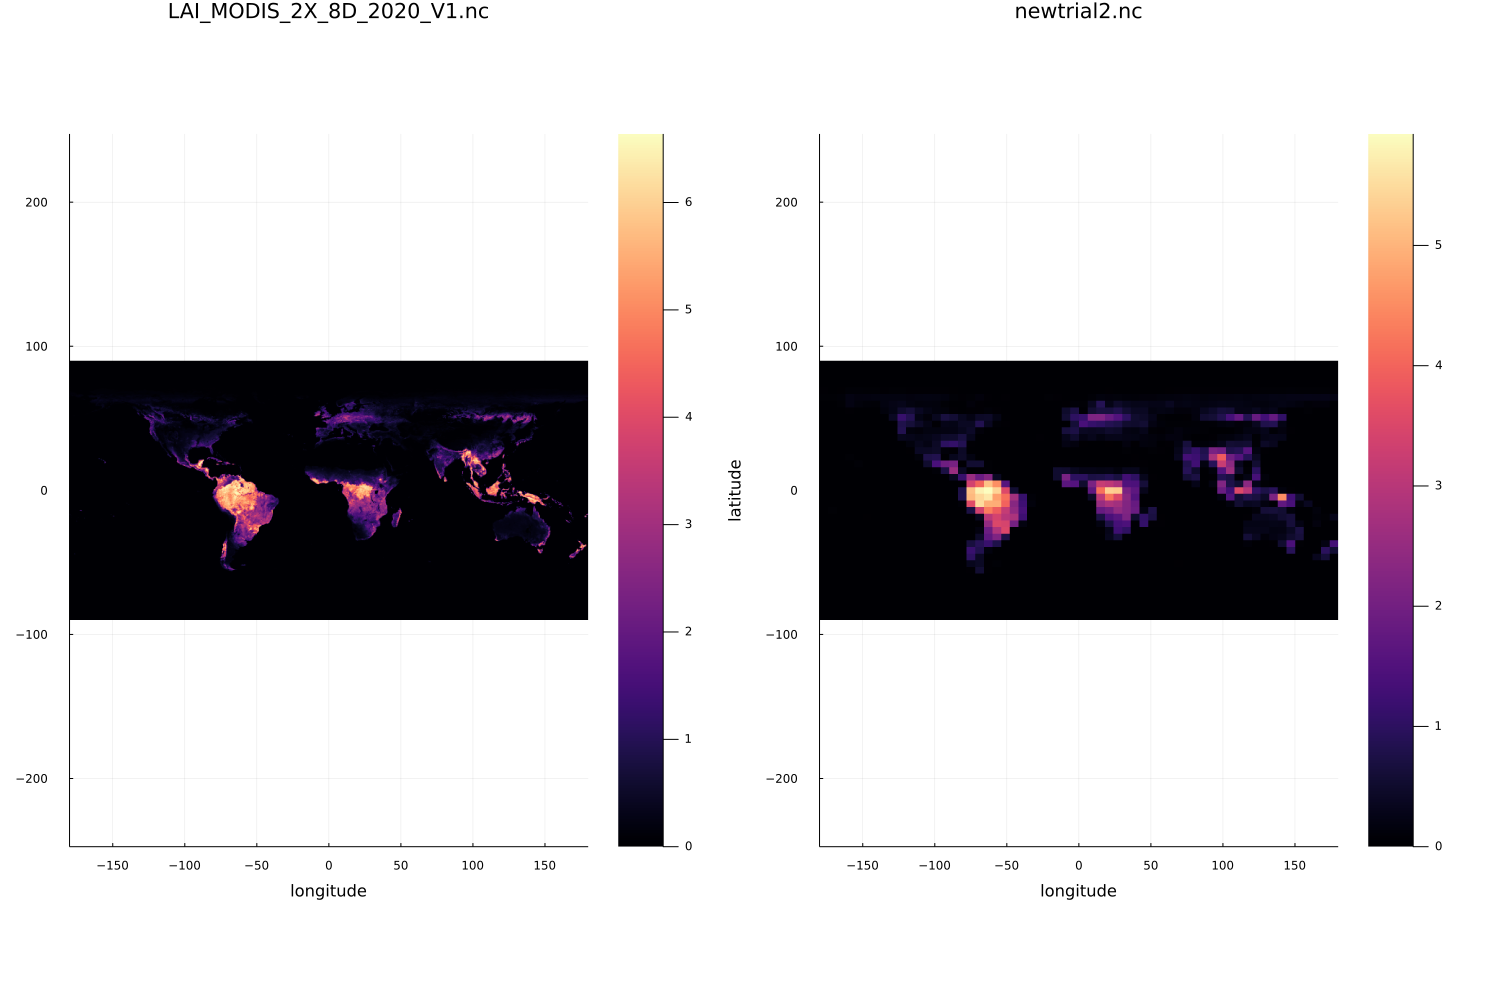

In [12]:
hmps = Dict("initial_data" => plot_ncdf(file),
            "regridded_data" => plot_ncdf(new_file))

plot(hmps["initial_data"], hmps["regridded_data"], layout = (1, 2))

---

In [18]:
fl = "download.nc"
ds = NCDataset(fl, "r")

NCDataset: download.nc
Group: /

Dimensions
   longitude = 3600
   latitude = 1801
   time = 72

Variables
  longitude   (3600)
    Datatype:    Float32
    Dimensions:  longitude
    Attributes:
     units                = degrees_east
     long_name            = longitude

  latitude   (1801)
    Datatype:    Float32
    Dimensions:  latitude
    Attributes:
     units                = degrees_north
     long_name            = latitude

  time   (72)
    Datatype:    Int32
    Dimensions:  time
    Attributes:
     units                = hours since 1900-01-01 00:00:00.0
     long_name            = time
     calendar             = gregorian

  u10   (3600 × 1801 × 72)
    Datatype:    Int16
    Dimensions:  longitude × latitude × time
    Attributes:
     scale_factor         = 0.0007444404736050951
     add_offset           = -5.3989384662695175
     _FillValue           = -32767
     missing_value        = -32767
     units                = m s**-1
     long_name            = 10 me

In [14]:
ds["time"][:]

72-element Vector{DateTime}:
 1987-01-02T00:00:00
 1987-01-02T01:00:00
 1987-01-02T02:00:00
 1987-01-02T03:00:00
 1987-01-02T04:00:00
 1987-01-02T05:00:00
 1987-01-02T06:00:00
 1987-01-02T07:00:00
 1987-01-02T08:00:00
 1987-01-02T09:00:00
 1987-01-02T10:00:00
 1987-01-02T11:00:00
 1987-01-02T12:00:00
 ⋮
 1987-01-04T12:00:00
 1987-01-04T13:00:00
 1987-01-04T14:00:00
 1987-01-04T15:00:00
 1987-01-04T16:00:00
 1987-01-04T17:00:00
 1987-01-04T18:00:00
 1987-01-04T19:00:00
 1987-01-04T20:00:00
 1987-01-04T21:00:00
 1987-01-04T22:00:00
 1987-01-04T23:00:00

In [58]:
rgg = Regridder(ds; latname="latitude", lonname="longitude", indname="time")

Regridder3D(RegridAxis{Int64, FT} where FT<:Union{DateTime, AbstractFloat}[RegridAxis{Int64, Float32}("latitude", -90.0f0, 90.0f0, 1801), RegridAxis{Int64, Float32}("longitude", 0.0f0, 359.9f0, 3600), RegridAxis{Int64, DateTime}("time", DateTime("1987-01-02T00:00:00"), DateTime("1987-01-04T23:00:00"), 72)])

In [59]:
rgo = Regridder3D(39, 60, rgg.axes[3].coordcard; indmin=minimum(rgg.axes[3]), indmax=maximum(rgg.axes[3]), latname="latitude", lonname="longitude", indname="time")

Regridder3D(RegridAxis{Int64, FT} where FT<:Union{DateTime, AbstractFloat}[RegridAxis{Int64, Float64}("latitude", -90.0, 90.0, 39), RegridAxis{Int64, Float64}("longitude", -180.0, 180.0, 60), RegridAxis{Int64, DateTime}("time", DateTime("1987-01-02T00:29:35"), DateTime("1987-01-04T22:30:25"), 72)])

In [60]:
dimwise_intervals(rgg)

RegridAxis{Int64, Float32}("latitude", -90.0f0, 90.0f0, 1801)
RegridAxis{Int64, Float32}("longitude", 0.0f0, 359.9f0, 3600)
RegridAxis{Int64, DateTime}("time", DateTime("1987-01-02T00:00:00"), DateTime("1987-01-04T23:00:00"), 72)


Dict{String, Vector{T} where T} with 3 entries:
  "latitude"  => OpenInterval{Float32}[-90.0..-89.9001 (open), -89.9001..-89.80…
  "time"      => OpenInterval{DateTime}[1987-01-02T00:00:00..1987-01-02T00:59:1…
  "longitude" => OpenInterval{Float32}[0.0..0.0999722 (open), 0.0999722..0.1999…

In [61]:
new_file = "banana.nc"

"banana.nc"

In [66]:
a=regrid_dataset(new_file, rgo, ds, ["u10", "v10"], regridding_op; force=true, latname="latitude", lonname="longitude", indname="time");

RegridAxis{Int64, Float64}("latitude", -90.0, 90.0, 39)
RegridAxis{Int64, Float64}("longitude", -180.0, 180.0, 60)
RegridAxis{Int64, DateTime}("time", DateTime("1987-01-02T00:29:35"), DateTime("1987-01-04T22:30:25"), 72)
RegridAxis{Int64, Float64}("latitude", -90.0, 90.0, 39)
RegridAxis{Int64, Float64}("longitude", -180.0, 180.0, 60)
RegridAxis{Int64, DateTime}("time", DateTime("1987-01-02T00:29:35"), DateTime("1987-01-04T22:30:25"), 72)


LoadError: InexactError: Int64(3.5006944444444445e6)

In [63]:
minimum(rgg.axes[3]):stepsize(rgg.axes[3]):maximum(rgg.axes[3])

DateTime("1987-01-02T00:29:35"):Dates.Millisecond(3550000):DateTime("1987-01-04T22:30:25")

In [67]:
minimum(rgo.axes[3])

LoadError: InexactError: Int64(3.5006944444444445e6)

In [56]:
typeof(rgg)

Regridder3D